<a href="https://colab.research.google.com/github/DrakeData/Bankruptcy_Prediction/blob/main/bankruptcy_pred_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Company Bankruptcy Prediction

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier

## Ingest
Donwloading the data from Kaggle's API

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp './drive/MyDrive/Colab Notebooks/API Keys/kaggle.json' ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download fedesoriano/company-bankruptcy-prediction

company-bankruptcy-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip company-bankruptcy-prediction

Archive:  company-bankruptcy-prediction.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.csv                


### Import Data

In [8]:
df = pd.read_csv('/content/data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

## EDA

In [9]:
df.shape

(6819, 96)

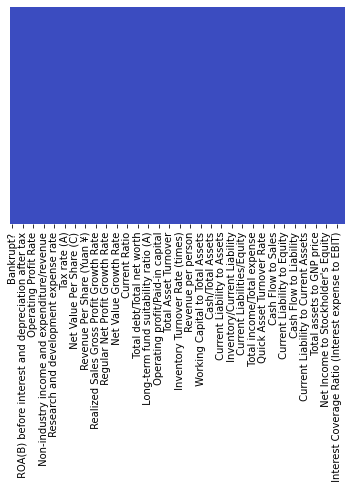

In [10]:
# Heatmap check for nulls in train set
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='coolwarm');

In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [12]:
# Check for duplicates
print(f'Number of duplicates values : {df.duplicated().sum()}')

Number of duplicates values : 0


In [62]:
# Check bankrupt (Y/N) column
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

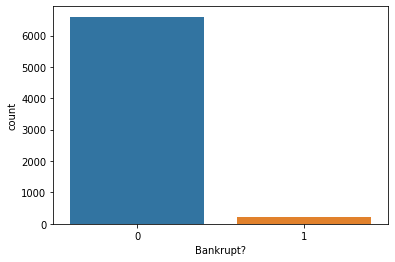

In [14]:
sns.countplot(x='Bankrupt?', data=df);

Looks like there are a high amount of 'No' compared to 'Yes' in the 'Bankrupt?' column, which means that this data set is highly unbalanced.

### Rebalence data

In [15]:
# Separate majority and minority classes
df_majority = df[df['Bankrupt?']==0]
df_minority = df[df['Bankrupt?']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6599,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Bankrupt?'].value_counts()

0    6599
1    6599
Name: Bankrupt?, dtype: int64

In [16]:
df_upsampled.shape

(13198, 96)

### Check for outliers

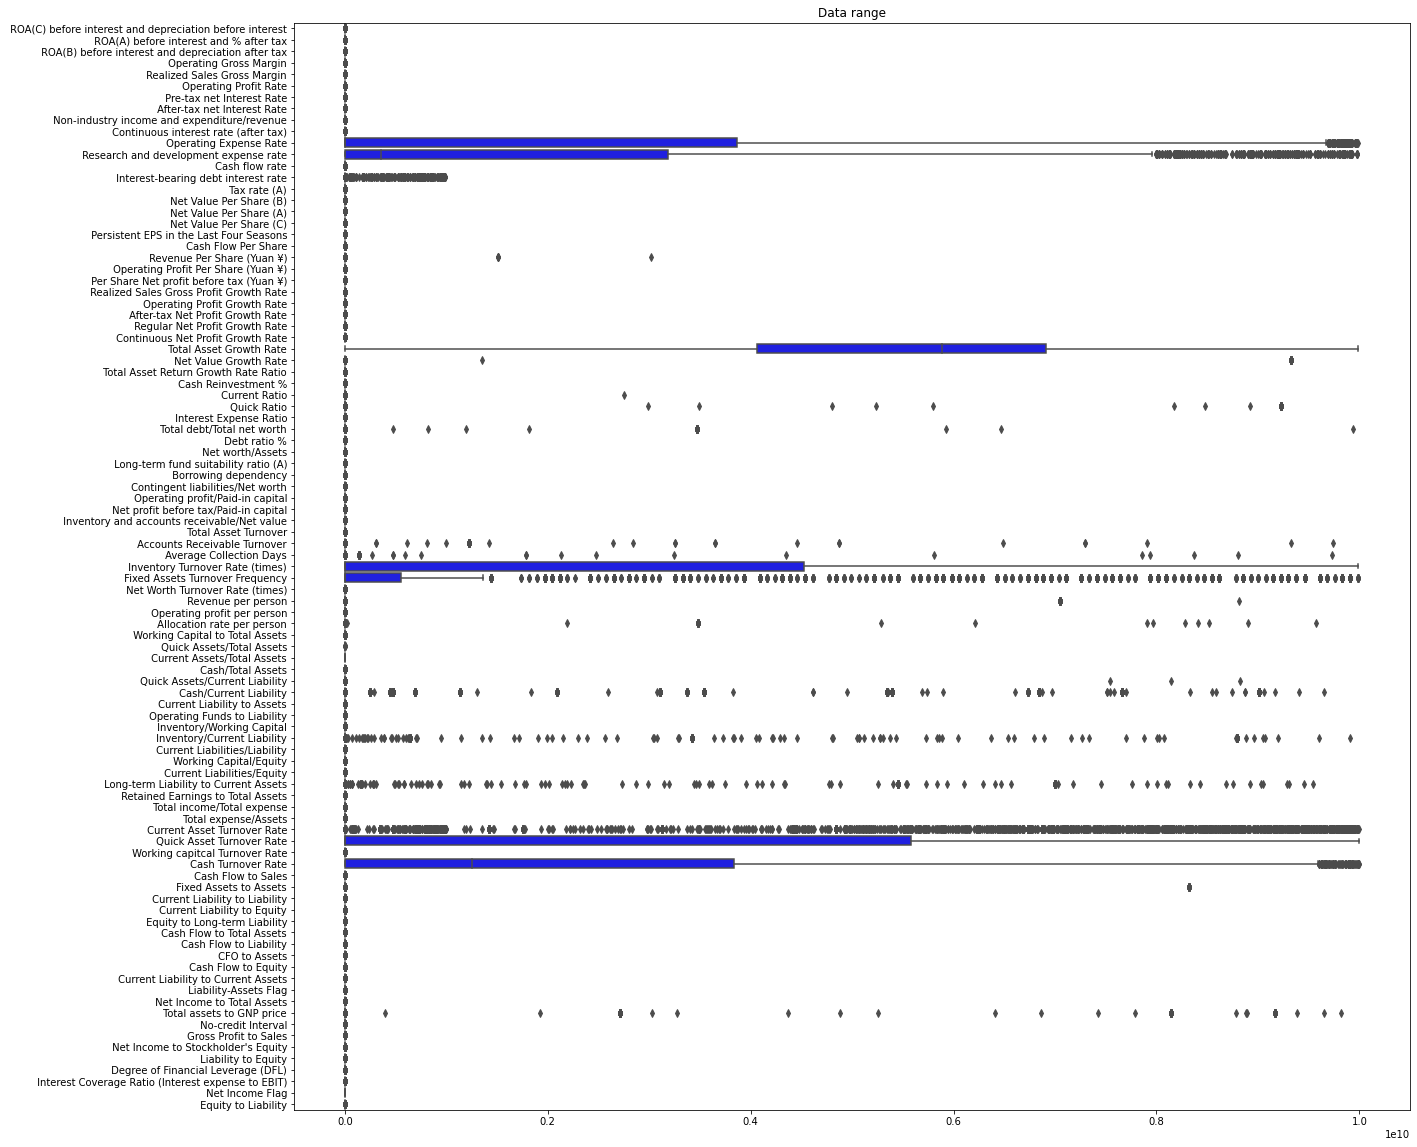

In [17]:
plt.figure(figsize=(20,20))
sns.boxplot(data=df_upsampled.drop(['Bankrupt?'], axis=1), orient='h', color='blue')
plt.title('Data range')
plt.show()

Code caps the numeric columns by looking at the quantile values between .01 and .99 and replaces the value to the closest quantile in the range.

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'

def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

final_df = cap_data(df_upsampled)

capping the  Bankrupt?
capping the   ROA(C) before interest and depreciation before interest
capping the   ROA(A) before interest and % after tax
capping the   ROA(B) before interest and depreciation after tax
capping the   Operating Gross Margin
capping the   Realized Sales Gross Margin
capping the   Operating Profit Rate
capping the   Pre-tax net Interest Rate
capping the   After-tax net Interest Rate
capping the   Non-industry income and expenditure/revenue
capping the   Continuous interest rate (after tax)
capping the   Operating Expense Rate
capping the   Research and development expense rate
capping the   Cash flow rate
capping the   Interest-bearing debt interest rate
capping the   Tax rate (A)
capping the   Net Value Per Share (B)
capping the   Net Value Per Share (A)
capping the   Net Value Per Share (C)
capping the   Persistent EPS in the Last Four Seasons
capping the   Cash Flow Per Share
capping the   Revenue Per Share (Yuan ¥)
capping the   Operating Profit Per Share (Yuan

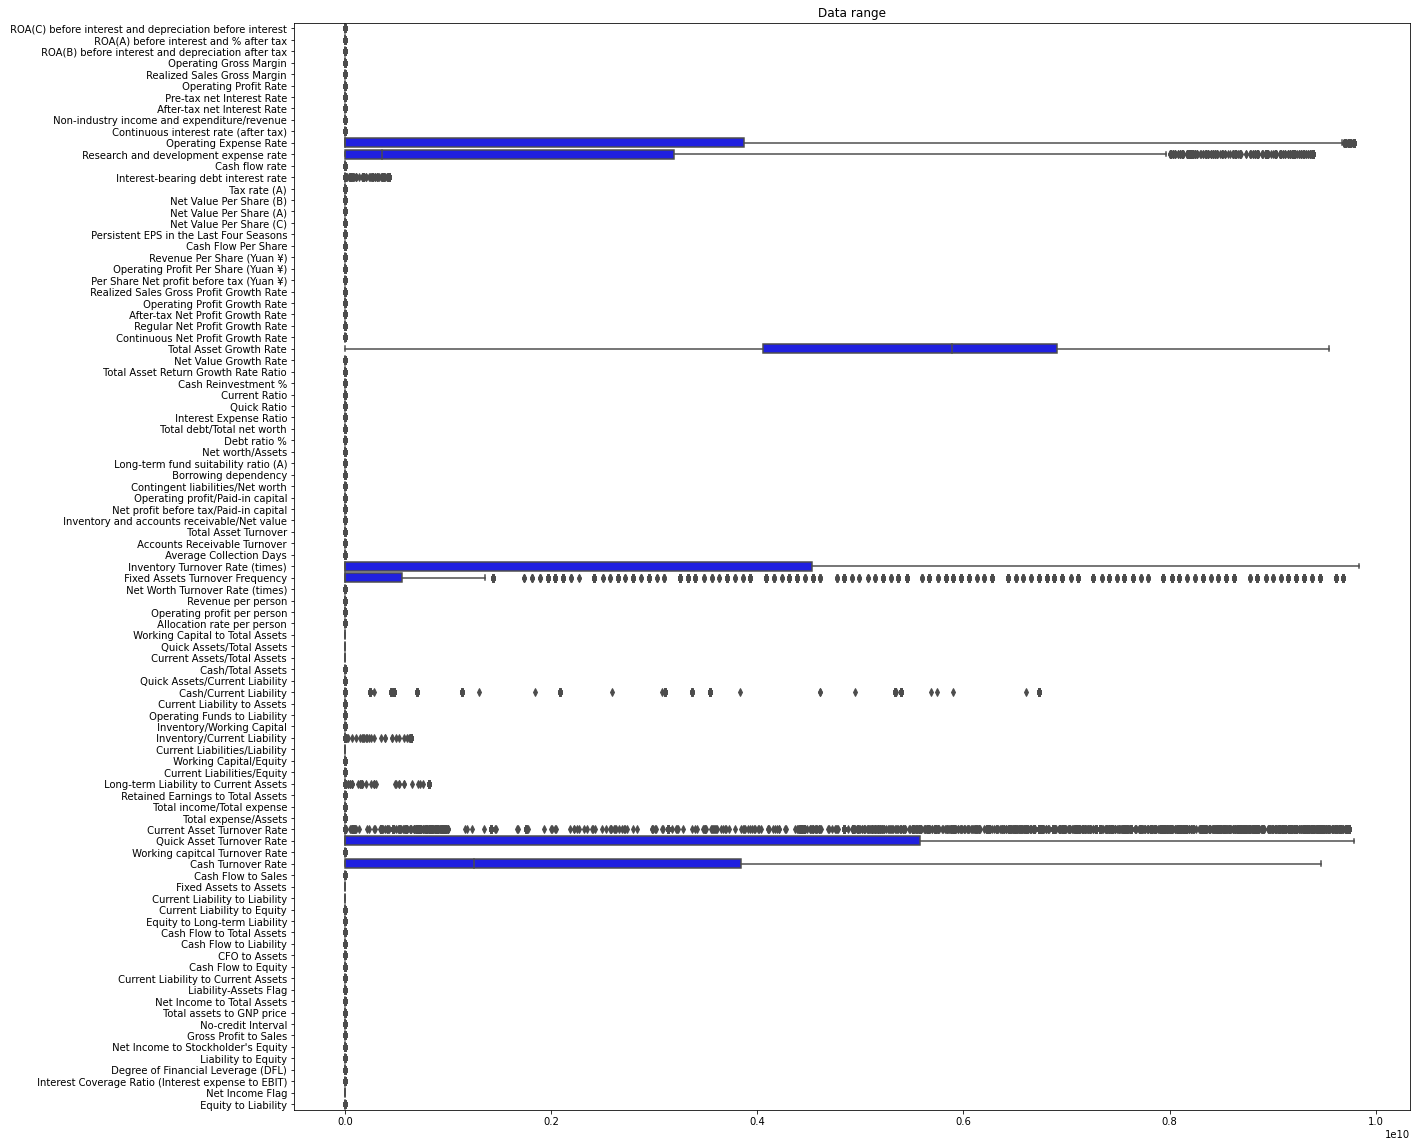

In [19]:
plt.figure(figsize=(20,20))
sns.boxplot(data=final_df.drop(['Bankrupt?'], axis=1), orient='h', color='blue')
plt.title('Data range')
plt.show()

## Modeling
From the viewpoint of a savvy investor, my objective would be to build a model that can accurately determine that a business will not file for bankruptcy. For this, we would want to compare the precision score for 0s and verify which model has the highest score.

In [20]:
# defining dependent and independent variables
x = final_df.drop('Bankrupt?', axis=1)
y = final_df['Bankrupt?']

In [21]:
# split data into 80% train & 20% test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=0)

In [22]:
# Scale Data
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

### Support Vector Machine (SVM) Model

In [23]:
# Set up model
svc = SVC(kernel='rbf', probability=True)
svc.fit(x_train_s, y_train)

# Get confusion matrix
y_pred = svc.predict(x_test_s)
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[1148  120]
 [  47 1325]]


In [24]:
# Check accuracy
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score = {acc}')
print(f'Classification Report {classification_report(y_test, y_pred)}')

Accuracy score = 0.9367424242424243
Classification Report               precision    recall  f1-score   support

           0       0.96      0.91      0.93      1268
           1       0.92      0.97      0.94      1372

    accuracy                           0.94      2640
   macro avg       0.94      0.94      0.94      2640
weighted avg       0.94      0.94      0.94      2640



Looking at the classification report, the SVM was able to accurately predict around 96% of no (0) bankruptcies and around 92% yes (1) bankruptcies (seen in the precision column). The overall accuracy of this classification model is around 93.7%.

In [25]:
svc_probs = svc.predict_proba(x_test_s)
svc_auc = roc_auc_score(y_test, svc_probs[:, 1])
print('Prediction: AUROC = %.3f' % (svc_auc))

Prediction: AUROC = 0.977


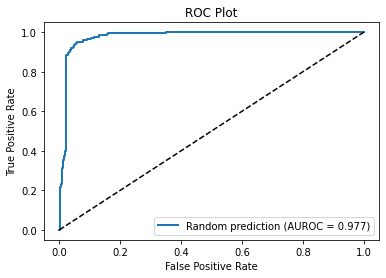

In [26]:
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs[:, 1])

plt.plot(svc_fpr, svc_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

#### Tuning the SVM Model
To try and enhance our SVM model, I will see what changing the kernel type from Radial-basis function (rbf) to the poly algorithm. See [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for other kernel options for future review.

In [27]:
# Set up model
svc2 = SVC(kernel='poly', probability=True)
svc2.fit(x_train_s, y_train)

# Get confusion matrix
y_pred2 = svc2.predict(x_test_s)
cm2 = confusion_matrix(y_test, y_pred2)
print(f'Confusion matrix:\n {cm2}')

Confusion matrix:
 [[1178   90]
 [  24 1348]]


In [28]:
# Check accuracy
acc2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy score = {acc2}')
print(f'Classification Report {classification_report(y_test, y_pred2)}')

Accuracy score = 0.9568181818181818
Classification Report               precision    recall  f1-score   support

           0       0.98      0.93      0.95      1268
           1       0.94      0.98      0.96      1372

    accuracy                           0.96      2640
   macro avg       0.96      0.96      0.96      2640
weighted avg       0.96      0.96      0.96      2640



There was a slight increase in preformance compared to the first SVC model.

In [29]:
svc_probs2 = svc2.predict_proba(x_test_s)
svc_auc2 = roc_auc_score(y_test, svc_probs2[:, 1])
print('Prediction: AUROC = %.3f' % (svc_auc2))

Prediction: AUROC = 0.987


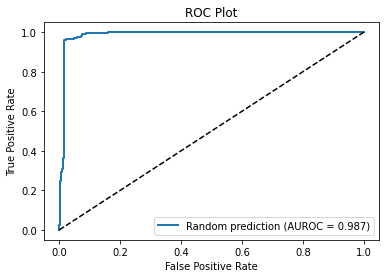

In [30]:
svc_fpr2, svc_tpr2, _ = roc_curve(y_test, svc_probs2[:, 1])

plt.plot(svc_fpr2, svc_tpr2, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc_auc2)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

#### Testing SVM Regularization Parameter
From [sklearn's documentatoin](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty. Default = 1.0

In [31]:
# Set up model
svc3 = SVC(kernel='rbf', C=2, probability=True)
svc3.fit(x_train_s, y_train)

# Get confusion matrix
y_pred3 = svc3.predict(x_test_s)
cm3 = confusion_matrix(y_test, y_pred3)
print(f'Confusion matrix:\n {cm3}')

Confusion matrix:
 [[1163  105]
 [  33 1339]]


In [32]:
# Check accuracy
acc3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy score = {acc3}')
print(f'Classification Report {classification_report(y_test, y_pred3)}')

Accuracy score = 0.9477272727272728
Classification Report               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1268
           1       0.93      0.98      0.95      1372

    accuracy                           0.95      2640
   macro avg       0.95      0.95      0.95      2640
weighted avg       0.95      0.95      0.95      2640



The precision and recall score slightly decrease from the second SVM model by a couple points with aprecision score for 0s around 97%.

In [33]:
svc3_probs = svc3.predict_proba(x_test)
svc3_auc = roc_auc_score(y_test, svc3_probs[:, 1])
print('Prediction: AUROC = %.3f' % (svc3_auc))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Prediction: AUROC = 0.504


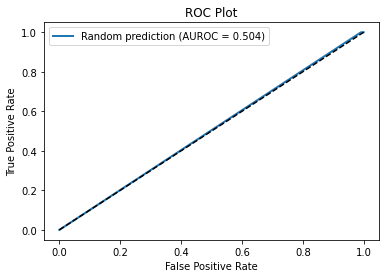

In [34]:
svc_fpr3, svc_tpr3, _ = roc_curve(y_test, svc3_probs[:, 1])

plt.plot(svc_fpr3, svc_tpr3, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc3_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Logistic Regression Model

In [35]:
# Set up model
log_regre = LogisticRegression(max_iter=1000)
log_regre.fit(x_train_s, y_train)

# Get confusion matrix
y_pred4 = log_regre.predict(x_test_s)
lr_auc = roc_auc_score(y_test, y_pred4)
cm4 = confusion_matrix(y_test, y_pred4)
print(f'Confusion matrix:\n {cm4}')

Confusion matrix:
 [[1113  155]
 [ 126 1246]]


In [36]:
# Check accuracy
acc2 = accuracy_score(y_test, y_pred4)
print(f'Accuracy score = {acc2}')
print(f'Classification Report {classification_report(y_test, y_pred4)}')

Accuracy score = 0.893560606060606
Classification Report               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1268
           1       0.89      0.91      0.90      1372

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640



Looking at the classification report, the Logistic Regression Model was able to accurately predict around 90% of no (0) bankruptcies and around 89% yes (1) bankruptcies (seen in the precision column). The overall accuracy of this classification model is around 89.4%. For our objective, the 0s precision score is decent and can be reliable.

In [37]:
lr_probs = svc.predict_proba(x_test_s)
lr_auc = roc_auc_score(y_test, lr_probs[:, 1])
print('Prediction: AUROC = %.3f' % (lr_auc))

Prediction: AUROC = 0.977


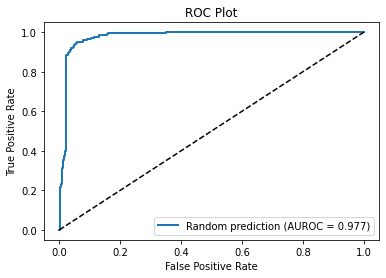

In [38]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs[:, 1])

plt.plot(lr_fpr, lr_tpr,  linewidth=2, label='Random prediction (AUROC = %0.3f)' % lr_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Naive Bayes Model

In [39]:
# Set up model
nb = GaussianNB()
nb.fit(x_train_s, y_train)

# Get confusion matrix
y_pred3 = nb.predict(x_test_s)
cm = confusion_matrix(y_test, y_pred3)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[1134  134]
 [ 355 1017]]


In [40]:
# Check accuracy
acc3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy score = {acc3}')
print(f'Classification Report {classification_report(y_test, y_pred3)}')

Accuracy score = 0.8147727272727273
Classification Report               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1268
           1       0.88      0.74      0.81      1372

    accuracy                           0.81      2640
   macro avg       0.82      0.82      0.81      2640
weighted avg       0.82      0.81      0.81      2640



Similar to the Logistic Regression Model, the Naive Bayes Model has a lower precision score for 0s (57%). The model is better at predicting 1s though, which is if a company will go bankrupt. This could be important to investors, but it strays away from the main objective.

In [41]:
nb_probs = nb.predict_proba(x_test_s)
nb_auc = roc_auc_score(y_test, nb_probs[:, 1])
print('Prediction: AUROC = %.3f' % (nb_auc))

Prediction: AUROC = 0.911


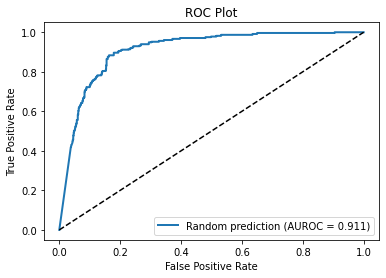

In [42]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs[:,1])

plt.plot(nb_fpr, nb_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % nb_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

## Conclusion
After performing an EDA, I was able to identify that the data set had several outliers and was unbalanced. We also needed to standerize the data to make sure it is consitant. These were addressed so that the noise can be limited in the data and passed through several different types of models. After analyzing the precision, recall, and accuracy scores, the model the performed the best was the SMV3 model where I tuned the C score to 2. Clarifying the C score helps the model avoid misclassifying variables, which improves overall accuracy. The precision score for 0s was also the highest out of all the models with it being around 98%, which lines up with the objective to predict companies that will not file for bankruptcy.

# Assignment 5: Company Bankruptcy Prediction (Continued)
This section we will be using Random Forest Classifier, Gradient Boosted Trees, and Extra Trees to try and predict company bankruptcy.

In [43]:
# defining dependent and independent variables
x = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# split data into 80% train & 20% test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=0)

## EDA

In [44]:
x_train.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,...,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.0,5455.000000
mean,0.504749,0.558201,0.553187,0.607820,0.607803,0.998693,0.797126,0.809022,0.303641,0.781323,1.979058e+09,1.977986e+09,0.467252,1.583355e+07,0.115028,0.190413,0.190395,0.190433,0.228594,0.323335,1.660862e+06,0.108757,0.184200,0.022434,0.847951,0.689074,0.689087,0.217663,5.531443e+09,1.710357e+06,0.264259,0.379502,5.041247e+05,7.567369e+06,0.631008,3.797434e+06,0.113876,0.886124,0.008949,0.374717,...,0.521031,0.123244,3.109074e+06,3.144711e+07,0.091197,0.353420,0.277235,5.574896e+07,0.761562,0.735682,0.331489,5.749287e+07,0.934678,0.002585,0.029095,1.183733e+09,2.172506e+09,0.594014,2.481238e+09,0.671518,1.525206e+06,0.761562,0.331489,0.115622,0.649363,0.461535,0.592741,0.315534,0.031694,0.000917,0.807596,2.151971e+07,0.623921,0.607818,0.840407,0.280427,0.027533,0.565373,1.0,0.047205
std,0.0595

Column name:  ROA(C) before interest and depreciation before interest 
 Min: 0.0242772875737337 
 Max: 1.0


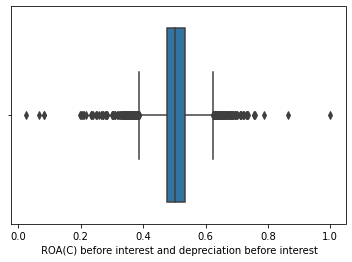

Column name:  ROA(A) before interest and % after tax 
 Min: 0.0 
 Max: 0.984736153510685


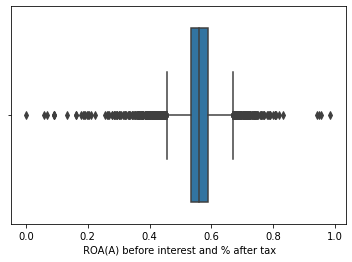

Column name:  ROA(B) before interest and depreciation after tax 
 Min: 0.0335135713903313 
 Max: 0.957760051394614


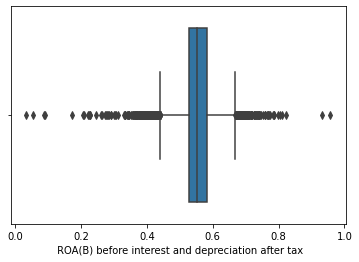

Column name:  Operating Gross Margin 
 Min: 0.0 
 Max: 1.0


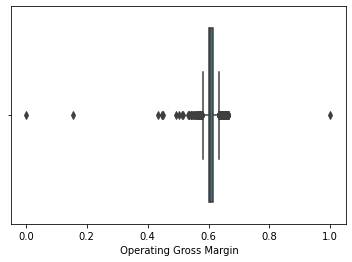

Column name:  Realized Sales Gross Margin 
 Min: 0.0 
 Max: 1.0


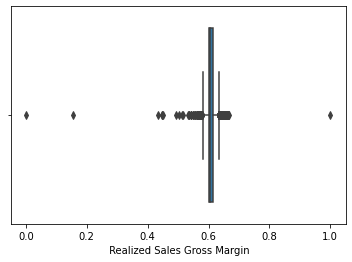

Column name:  Operating Profit Rate 
 Min: 0.0 
 Max: 1.0


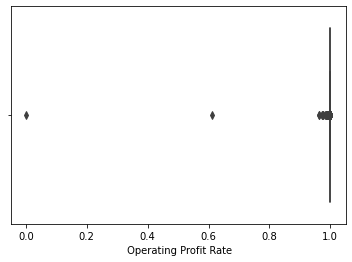

Column name:  Pre-tax net Interest Rate 
 Min: 0.0 
 Max: 1.0


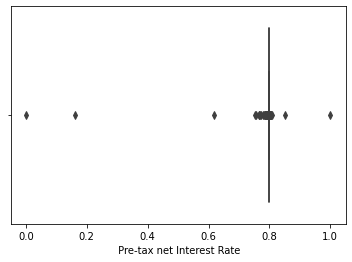

Column name:  After-tax net Interest Rate 
 Min: 0.0 
 Max: 1.0


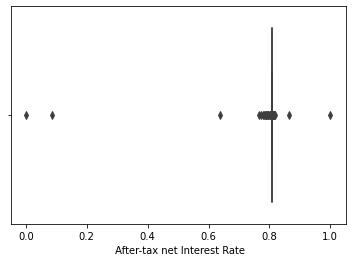

Column name:  Non-industry income and expenditure/revenue 
 Min: 0.0 
 Max: 1.0


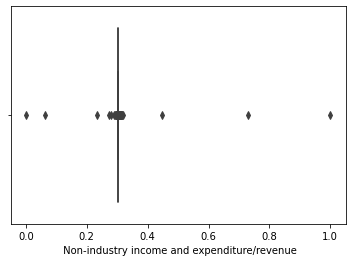

Column name:  Continuous interest rate (after tax) 
 Min: 0.0 
 Max: 1.0


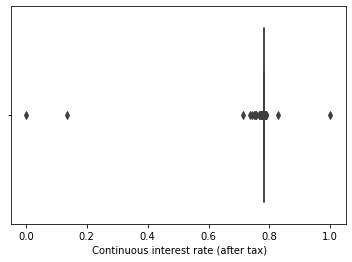

Column name:  Operating Expense Rate 
 Min: 0.0 
 Max: 9990000000.0


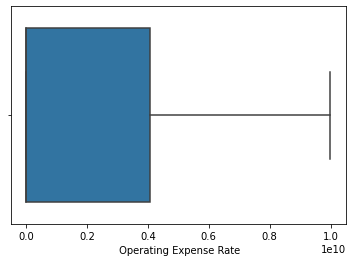

Column name:  Research and development expense rate 
 Min: 0.0 
 Max: 9980000000.0


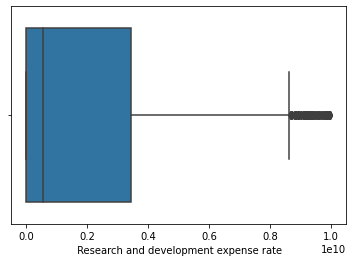

Column name:  Cash flow rate 
 Min: 0.0 
 Max: 1.0


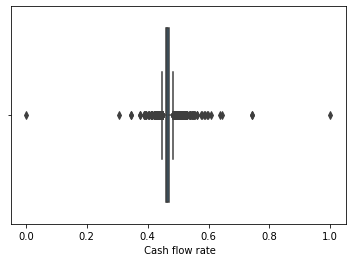

Column name:  Interest-bearing debt interest rate 
 Min: 0.0 
 Max: 990000000.0


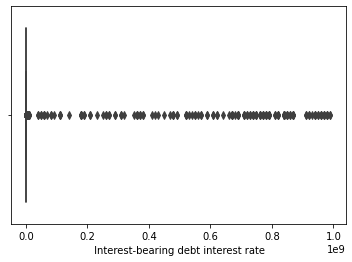

Column name:  Tax rate (A) 
 Min: 0.0 
 Max: 0.999696325539022


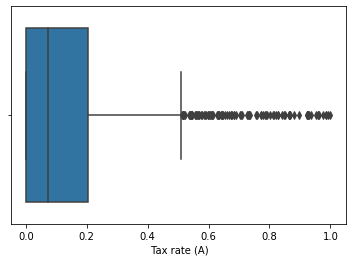

Column name:  Net Value Per Share (B) 
 Min: 0.0 
 Max: 1.0


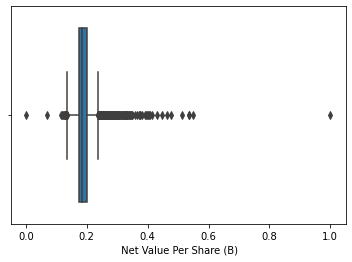

Column name:  Net Value Per Share (A) 
 Min: 0.0 
 Max: 1.0


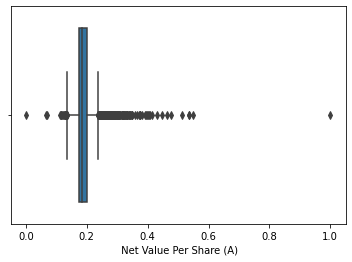

Column name:  Net Value Per Share (C) 
 Min: 0.0 
 Max: 1.0


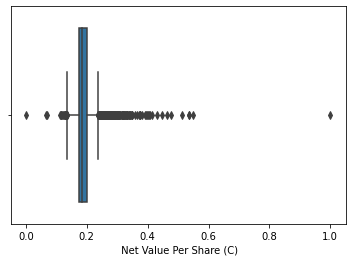

Column name:  Persistent EPS in the Last Four Seasons 
 Min: 0.0785667013330812 
 Max: 1.0


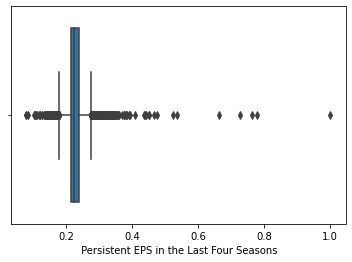

Column name:  Cash Flow Per Share 
 Min: 0.0 
 Max: 1.0


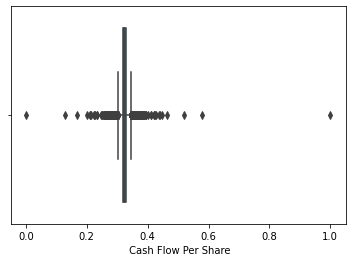

Column name:  Revenue Per Share (Yuan ¥) 
 Min: 0.0 
 Max: 3020000000.0


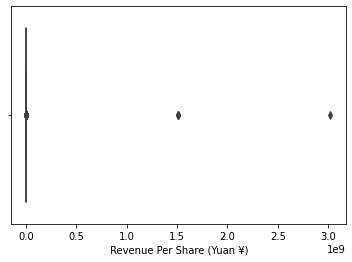

Column name:  Operating Profit Per Share (Yuan ¥) 
 Min: 0.0 
 Max: 1.0


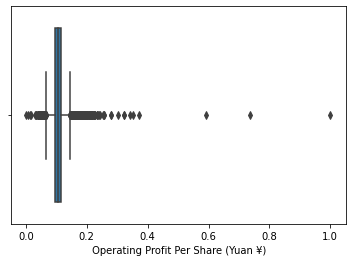

Column name:  Per Share Net profit before tax (Yuan ¥) 
 Min: 0.0091135045567522 
 Max: 1.0


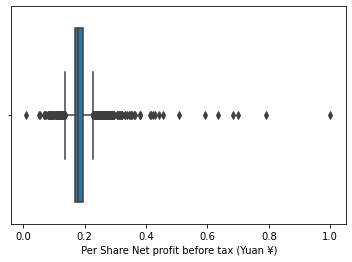

Column name:  Realized Sales Gross Profit Growth Rate 
 Min: 0.0 
 Max: 1.0


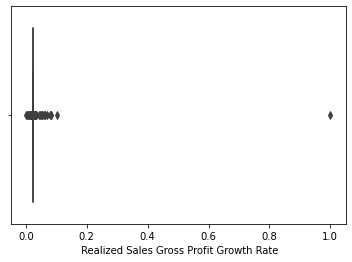

Column name:  Operating Profit Growth Rate 
 Min: 0.0 
 Max: 1.0


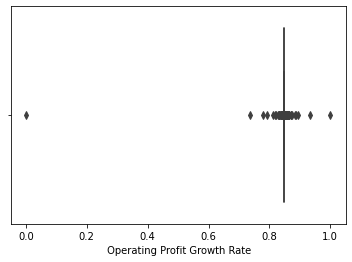

Column name:  After-tax Net Profit Growth Rate 
 Min: 0.0 
 Max: 1.0


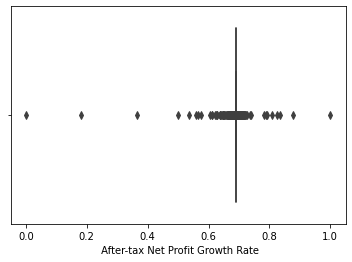

Column name:  Regular Net Profit Growth Rate 
 Min: 0.0 
 Max: 1.0


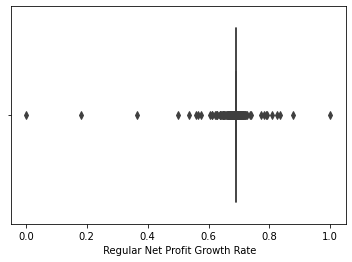

Column name:  Continuous Net Profit Growth Rate 
 Min: 0.0 
 Max: 1.0


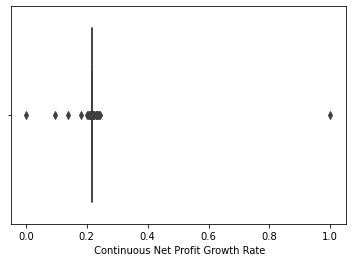

Column name:  Total Asset Growth Rate 
 Min: 0.0 
 Max: 9990000000.0


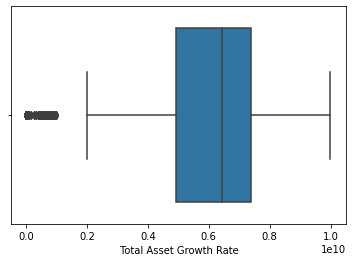

Column name:  Net Value Growth Rate 
 Min: 0.0 
 Max: 9330000000.0


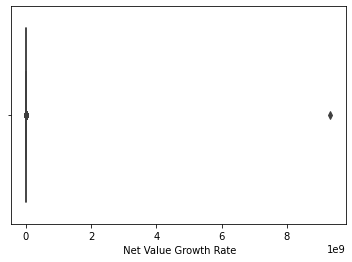

Column name:  Total Asset Return Growth Rate Ratio 
 Min: 0.0 
 Max: 1.0


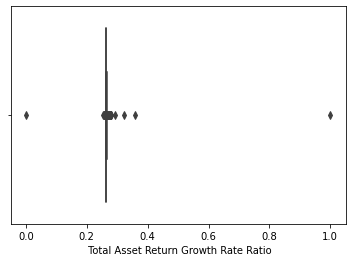

Column name:  Cash Reinvestment % 
 Min: 0.0 
 Max: 0.75994746842517


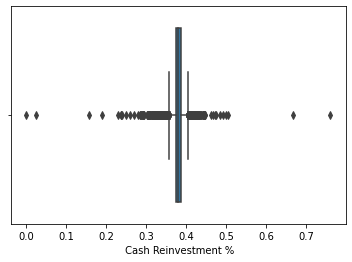

Column name:  Current Ratio 
 Min: 0.0001628700066458 
 Max: 2750000000.0


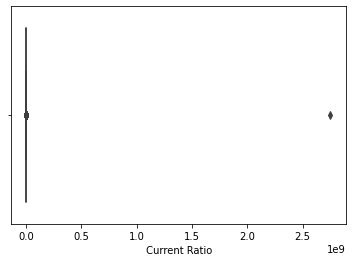

Column name:  Quick Ratio 
 Min: 0.0 
 Max: 9230000000.0


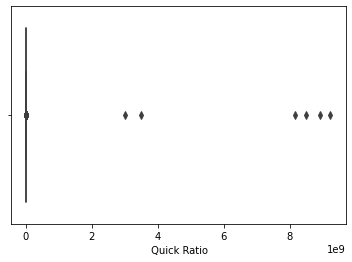

Column name:  Interest Expense Ratio 
 Min: 0.0 
 Max: 1.0


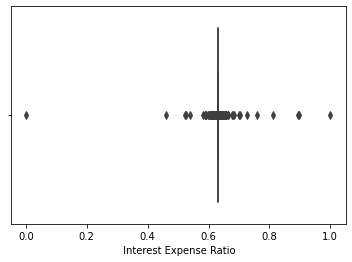

Column name:  Total debt/Total net worth 
 Min: 0.0 
 Max: 9940000000.0


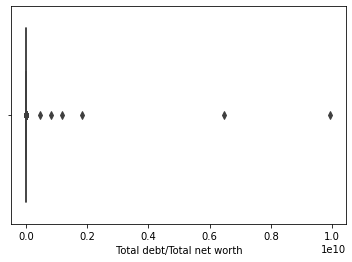

Column name:  Debt ratio % 
 Min: 0.0 
 Max: 1.0


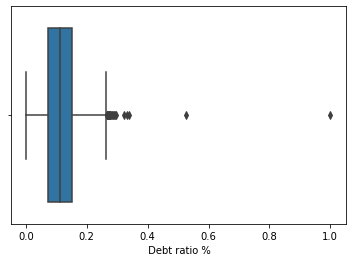

Column name:  Net worth/Assets 
 Min: 0.0 
 Max: 1.0


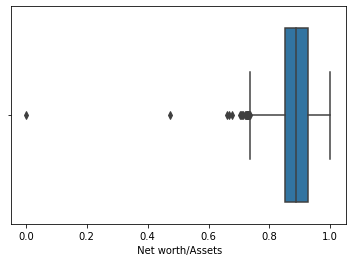

Column name:  Long-term fund suitability ratio (A) 
 Min: 0.0 
 Max: 1.0


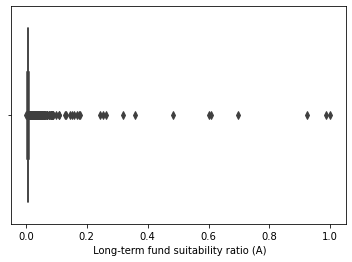

Column name:  Borrowing dependency 
 Min: 0.26203523730493 
 Max: 1.0


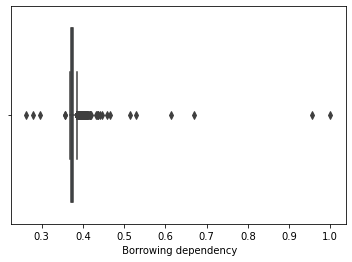

Column name:  Contingent liabilities/Net worth 
 Min: 0.0 
 Max: 1.0


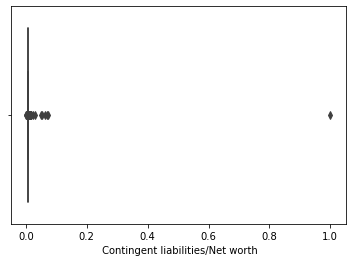

Column name:  Operating profit/Paid-in capital 
 Min: 0.0 
 Max: 1.0


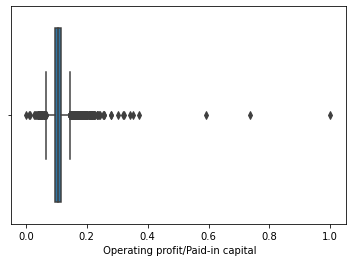

Column name:  Net profit before tax/Paid-in capital 
 Min: 0.0524394842017947 
 Max: 1.0


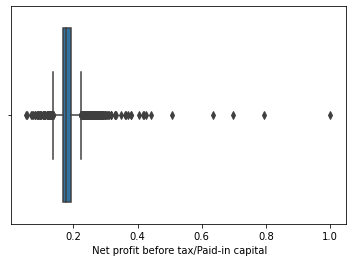

Column name:  Inventory and accounts receivable/Net value 
 Min: 0.351418699584552 
 Max: 0.588075394246962


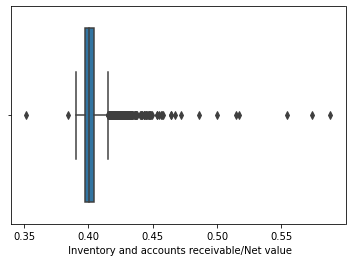

Column name:  Total Asset Turnover 
 Min: 0.0 
 Max: 1.0


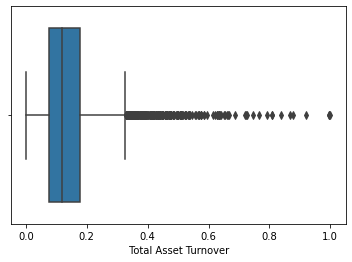

Column name:  Accounts Receivable Turnover 
 Min: 0.0 
 Max: 9740000000.0


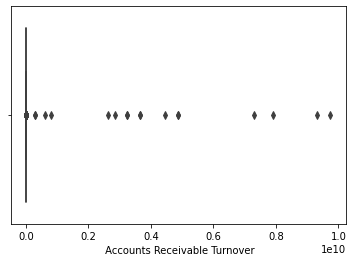

Column name:  Average Collection Days 
 Min: 0.0 
 Max: 9730000000.0


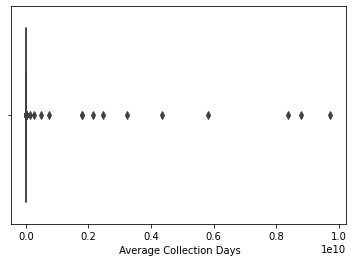

Column name:  Inventory Turnover Rate (times) 
 Min: 0.0 
 Max: 9990000000.0


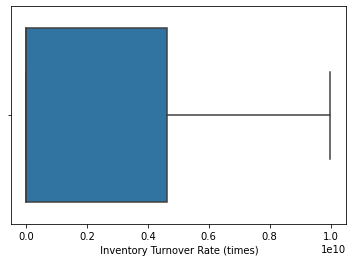

Column name:  Fixed Assets Turnover Frequency 
 Min: 0.0 
 Max: 9990000000.0


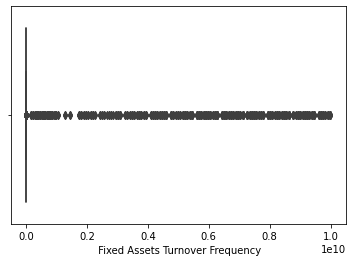

Column name:  Net Worth Turnover Rate (times) 
 Min: 0.0 
 Max: 1.0


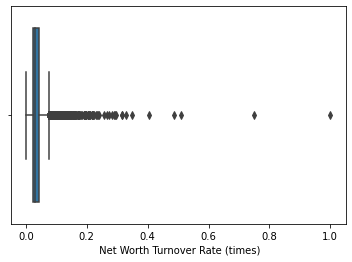

Column name:  Revenue per person 
 Min: 0.0 
 Max: 8810000000.0


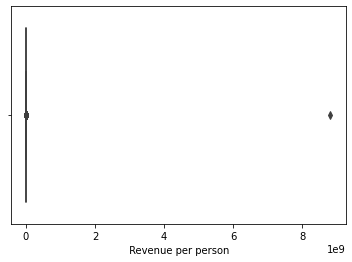

Column name:  Operating profit per person 
 Min: 0.0 
 Max: 1.0


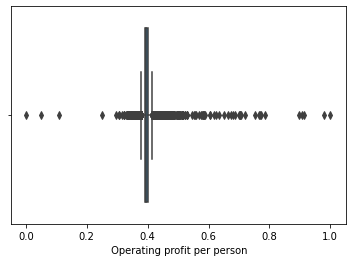

Column name:  Allocation rate per person 
 Min: 0.0 
 Max: 9570000000.0


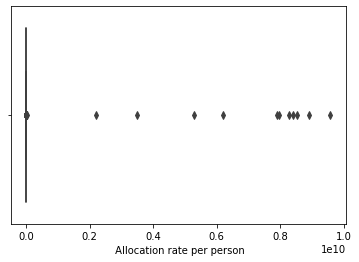

Column name:  Working Capital to Total Assets 
 Min: 0.0 
 Max: 1.0


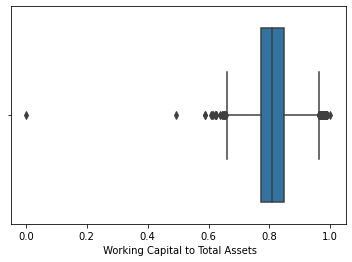

Column name:  Quick Assets/Total Assets 
 Min: 0.0 
 Max: 1.0


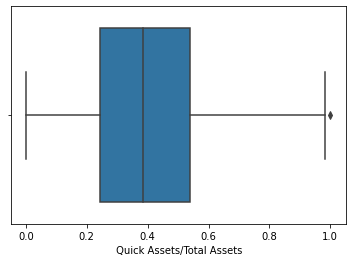

Column name:  Current Assets/Total Assets 
 Min: 0.0 
 Max: 1.0


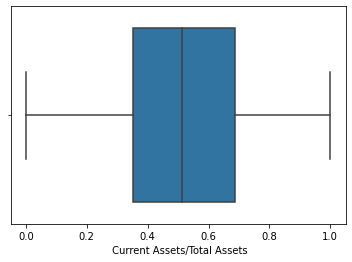

Column name:  Cash/Total Assets 
 Min: 0.0 
 Max: 1.0


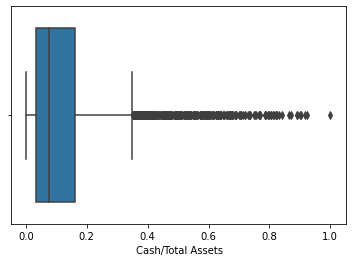

Column name:  Quick Assets/Current Liability 
 Min: 0.0 
 Max: 8820000000.0


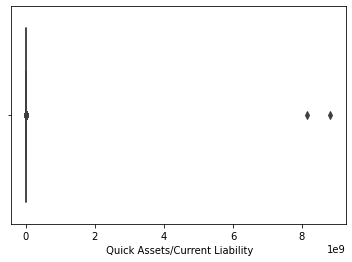

Column name:  Cash/Current Liability 
 Min: 0.0 
 Max: 9650000000.0


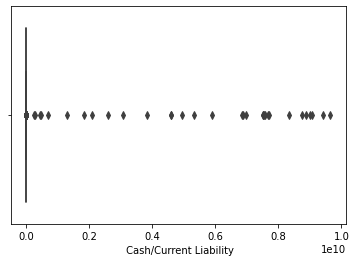

Column name:  Current Liability to Assets 
 Min: 0.0 
 Max: 1.0


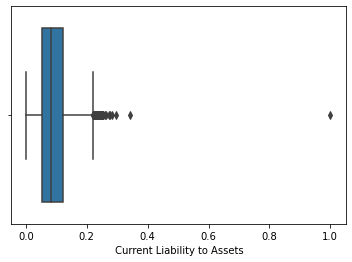

Column name:  Operating Funds to Liability 
 Min: 0.0 
 Max: 1.0


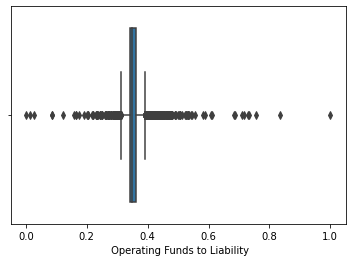

Column name:  Inventory/Working Capital 
 Min: 0.0 
 Max: 0.466867996035203


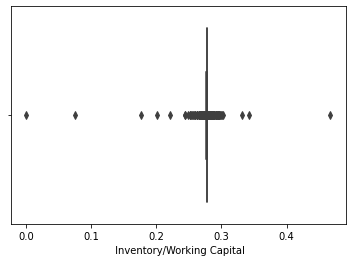

Column name:  Inventory/Current Liability 
 Min: 0.0 
 Max: 9910000000.0


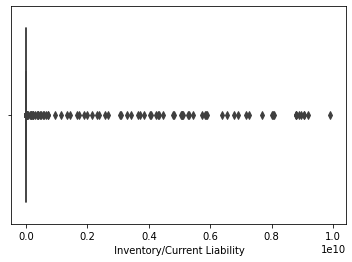

Column name:  Current Liabilities/Liability 
 Min: 0.0 
 Max: 1.0


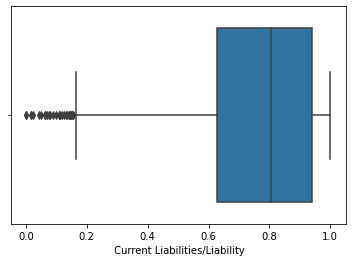

Column name:  Working Capital/Equity 
 Min: 0.0 
 Max: 0.825196505065642


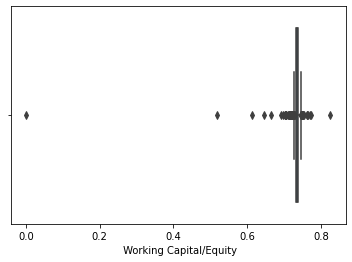

Column name:  Current Liabilities/Equity 
 Min: 0.241052683507238 
 Max: 1.0


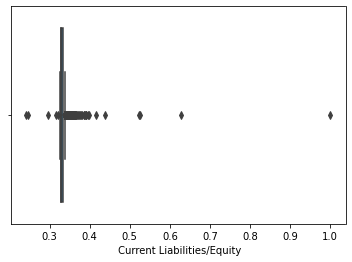

Column name:  Long-term Liability to Current Assets 
 Min: 0.0 
 Max: 9540000000.0


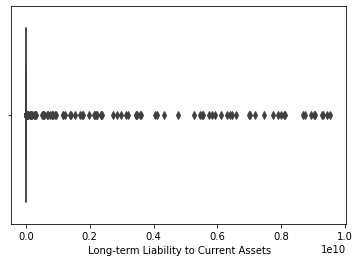

Column name:  Retained Earnings to Total Assets 
 Min: 0.0 
 Max: 1.0


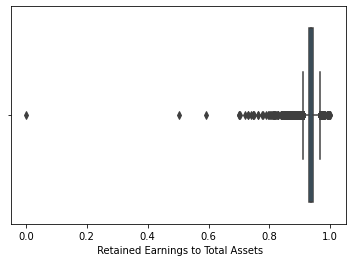

Column name:  Total income/Total expense 
 Min: 0.0 
 Max: 1.0


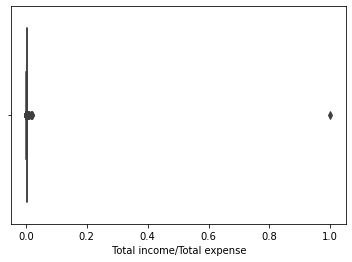

Column name:  Total expense/Assets 
 Min: 0.0 
 Max: 1.0


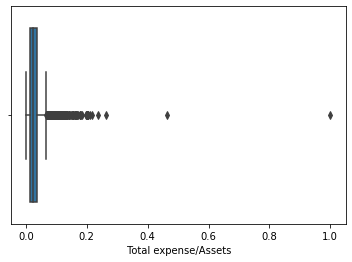

Column name:  Current Asset Turnover Rate 
 Min: 0.0 
 Max: 10000000000.0


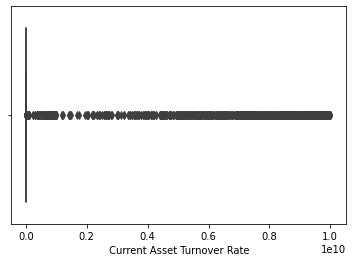

Column name:  Quick Asset Turnover Rate 
 Min: 0.0001000220321351 
 Max: 10000000000.0


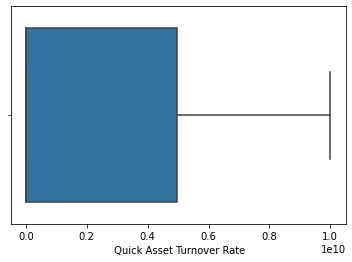

Column name:  Working capitcal Turnover Rate 
 Min: 0.0 
 Max: 1.0


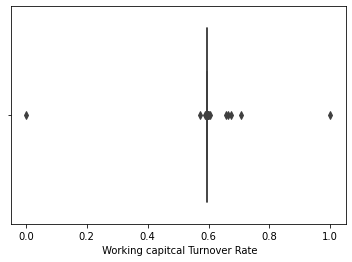

Column name:  Cash Turnover Rate 
 Min: 0.0 
 Max: 10000000000.0


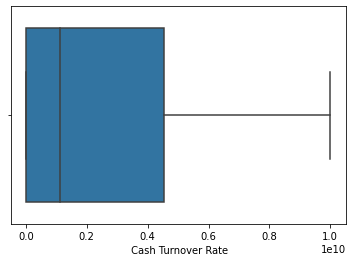

Column name:  Cash Flow to Sales 
 Min: 0.0 
 Max: 1.0


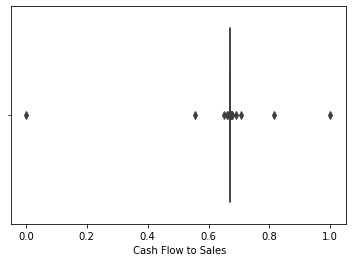

Column name:  Fixed Assets to Assets 
 Min: 0.0 
 Max: 8320000000.0


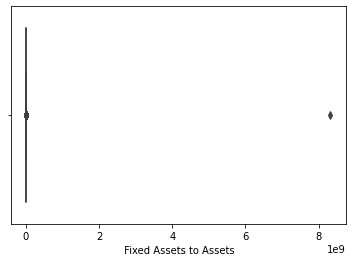

Column name:  Current Liability to Liability 
 Min: 0.0 
 Max: 1.0


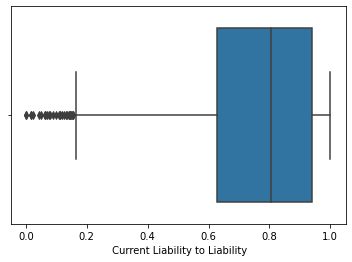

Column name:  Current Liability to Equity 
 Min: 0.241052683507238 
 Max: 1.0


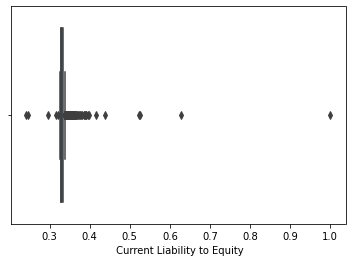

Column name:  Equity to Long-term Liability 
 Min: 0.0 
 Max: 0.92212804091503


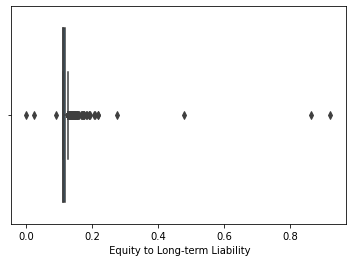

Column name:  Cash Flow to Total Assets 
 Min: 0.0 
 Max: 1.0


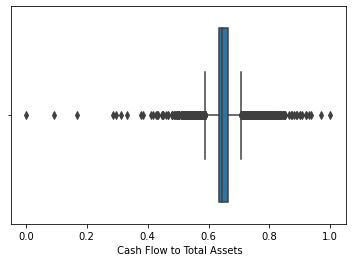

Column name:  Cash Flow to Liability 
 Min: 0.0 
 Max: 0.905119835412887


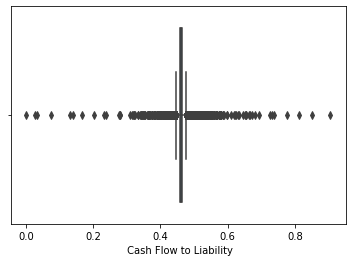

Column name:  CFO to Assets 
 Min: 0.0 
 Max: 1.0


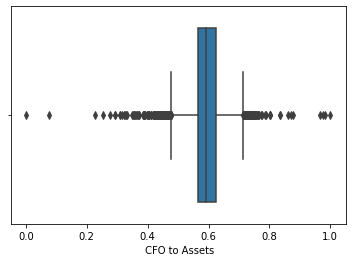

Column name:  Cash Flow to Equity 
 Min: 0.0 
 Max: 1.0


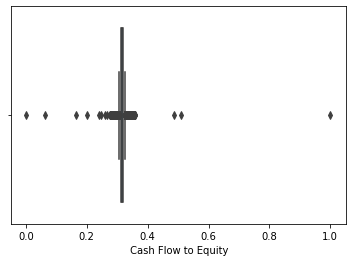

Column name:  Current Liability to Current Assets 
 Min: 0.0 
 Max: 0.916814252922595


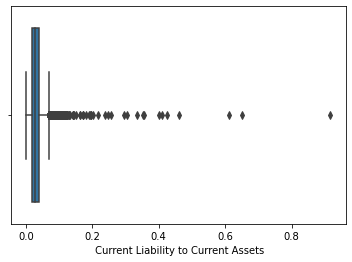

Column name:  Liability-Assets Flag 
 Min: 0 
 Max: 1


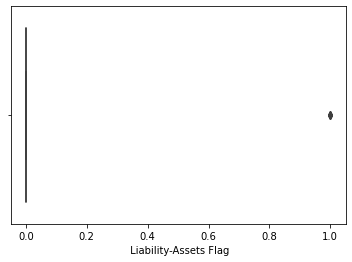

Column name:  Net Income to Total Assets 
 Min: 0.0 
 Max: 1.0


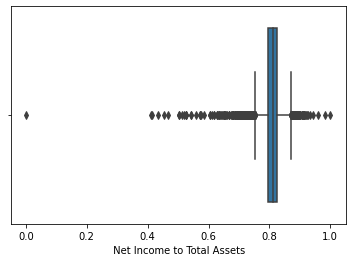

Column name:  Total assets to GNP price 
 Min: 0.0 
 Max: 9820000000.0


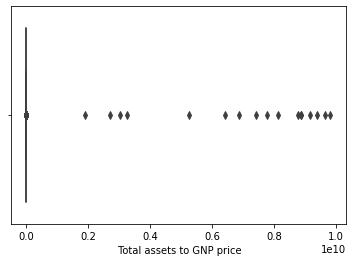

Column name:  No-credit Interval 
 Min: 0.0 
 Max: 1.0


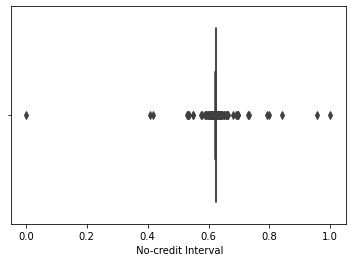

Column name:  Gross Profit to Sales 
 Min: 0.0 
 Max: 1.0


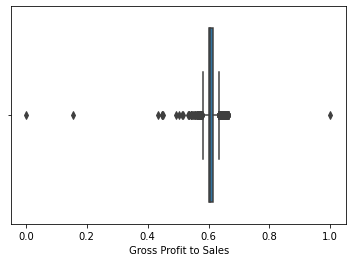

Column name:  Net Income to Stockholder's Equity 
 Min: 0.0 
 Max: 1.0


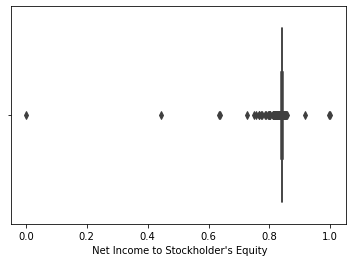

Column name:  Liability to Equity 
 Min: 0.182790358888349 
 Max: 1.0


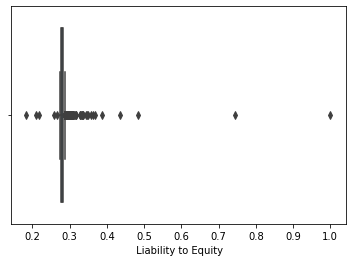

Column name:  Degree of Financial Leverage (DFL) 
 Min: 0.0024392971591892 
 Max: 1.0


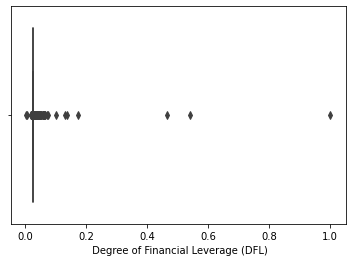

Column name:  Interest Coverage Ratio (Interest expense to EBIT) 
 Min: 0.0 
 Max: 0.736984956423991


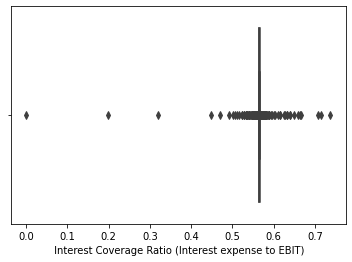

Column name:  Net Income Flag 
 Min: 1 
 Max: 1


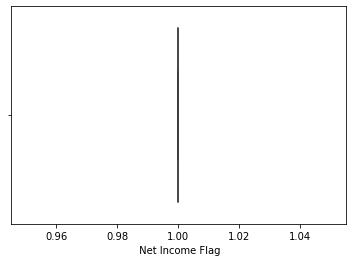

Column name:  Equity to Liability 
 Min: 0.0 
 Max: 1.0


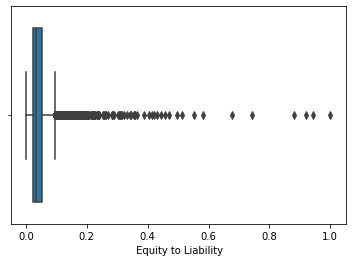

In [45]:
# Looking at min/max of columns
for col in x_train.columns:
  print(f"Column name: {col} \n Min: {x_train[col].min()} \n Max: {x_train[col].max()}")
  sns.boxplot(x=x_train[col])
  plt.show()

Since we will be using decision trees and random forest models, we do not need to standardize the data. Both models are not sensitive to the scale of the features and the splits of the trees are not influenced by other features.

## Modeling

### Random Forest Classifier

In [46]:
# Set up the parameters and distribution
param_dist = {"max_depth": [3, None],
             "max_features": randint(1,9),
             "min_samples_leaf": randint(1,9),
             "criterion": ["gini","entropy"]}
# Set up model
dec_tree = DecisionTreeClassifier()

# Instantiate RandomizedSearchCV
tree_cv = RandomizedSearchCV(dec_tree, param_distributions=param_dist, cv=5)

# Train model
tree_cv.fit(x_train, y_train)

# Predict
tree_pred = tree_cv.predict_proba(x_test)[:,1]
tree_pred1 = tree_cv.predict(x_test)

#### Check Accracy

In [47]:
tree_rocaucscore = roc_auc_score(y_test, tree_pred)
tree_f1score = f1_score(y_test, tree_pred1)
tree_accuracyscore = accuracy_score(y_test, tree_pred1)

print(f'ROC AUC Score: {tree_rocaucscore} \nF-1 Score: {tree_f1score} \nAccuracy Score: {tree_accuracyscore}')

ROC AUC Score: 0.9190885399485387 
F-1 Score: 0.0 
Accuracy Score: 0.966275659824047


The ROC AUC Score computes the area under the Receiver Operating Characteristic Curve (ROC) based off the prediction score. This measures the ability of the distinguish between classes, with the decision tree model having a decent performance around .87 without having to rebalence nor standardize the data.

The F-1 Score represents the harmonic mean of the precision and recall score, which is on a scale of 0 to 1 with 1 being it reaching the best value. The decision tree model had a low F-1 Score around .04.

The Accuracy Score computes subset accuracy, with 1 representing the best performance. Once again, the decision tree model had a high Accuracy Score around .96.




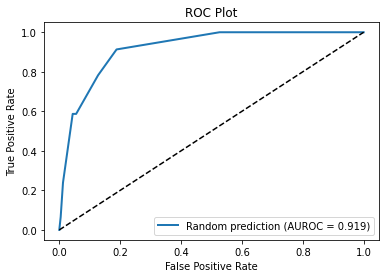

In [48]:
dt_fpr, dt_tpr, _ = roc_curve(y_test, tree_pred)

plt.plot(dt_fpr, dt_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % tree_rocaucscore)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Gradient Boosted Trees

In [49]:
# Set up model
grad_boost = GradientBoostingClassifier(n_estimators=20, 
                                        max_features=2,
                                        max_depth=2,
                                        random_state=0,
                                        criterion='friedman_mse')
# Train model
grad_boost.fit(x_train, y_train)

# Predict
tree_pred2 = grad_boost.predict_proba(x_test)[:,1]
tree_pred1_2 = grad_boost.predict(x_test)

In [50]:
grad_rocaucscore = roc_auc_score(y_test, tree_pred2)
grad_f1score = f1_score(y_test, tree_pred1_2)
grad_accuracyscore = accuracy_score(y_test, tree_pred1_2)

print(f'ROC AUC Score: {grad_rocaucscore} \nF-1 Score: {grad_f1score} \nAccuracy Score: {grad_accuracyscore}')

ROC AUC Score: 0.945338787358976 
F-1 Score: 0.2413793103448276 
Accuracy Score: 0.967741935483871


The ROC AUC Score computes the area under the Receiver Operating Characteristic Curve (ROC) based off the prediction score. This measures the ability of the distinguish between classes, with the decision tree model having a higher performance than the Random Forest Classifier with it being around .94 without having to rebalence nor standardize the data.

The F-1 Score is higher as well with it being .24.

The Accuracy Score is around the same with it being around .96.

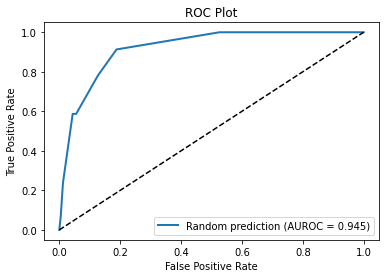

In [67]:
grad_fpr, grad_tpr, _ = roc_curve(y_test, tree_pred)

plt.plot(grad_fpr, grad_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % grad_rocaucscore)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

### Extra Trees

In [55]:
# Set up model
extra_tree = ExtraTreesClassifier(n_estimators=20, 
                                 max_features=2,
                                 max_depth=2,
                                 random_state=0,
                                 criterion='gini')

# Train model
extra_tree.fit(x_train, y_train)

# Predict
tree_pred3 = extra_tree.predict_proba(x_test)[:,1]
tree_pred1_3 = extra_tree.predict(x_test)

In [60]:
et_rocaucscore = roc_auc_score(y_test, tree_pred3)
et_f1score = f1_score(y_test, tree_pred1_3)
et_accuracyscore = accuracy_score(y_test, tree_pred1_3)

print(f'ROC AUC Score: {et_rocaucscore} \nF-1 Score: {et_f1score} \nAccuracy Score: {et_accuracyscore}')

ROC AUC Score: 0.7988553143761958 
F-1 Score: 0.0 
Accuracy Score: 0.966275659824047


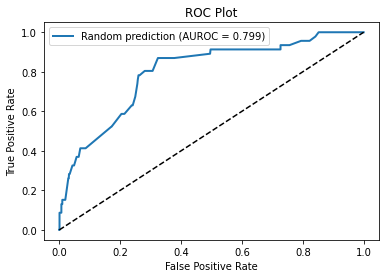

In [68]:
et_fpr, et_tpr, _ = roc_curve(y_test, tree_pred3)

plt.plot(et_fpr, et_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % et_rocaucscore)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()